## Visualizing various Model Selection chain outputs

Jeffrey S. Hazboun

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import json, pickle

In [3]:
import sys
sys.path.insert(0,'/Users/hazboun/software_development/la_forge/')
import la_forge.diagnostics as dg
import la_forge.core as co
from la_forge.rednoise import plot_rednoise_spectrum, plot_free_spec

In [308]:
psrname = 'J1600-3053'#'J1911+1347'#
chaindir = '/Users/hazboun/nanograv_detection/ent_ext_testing/{}/chrom_dmgp/'.format(psrname)

In [447]:
cH=co.HyperModelCore(label='PSR {}, DM Model Selection',
                     chaindir=chaindir)

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 850
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


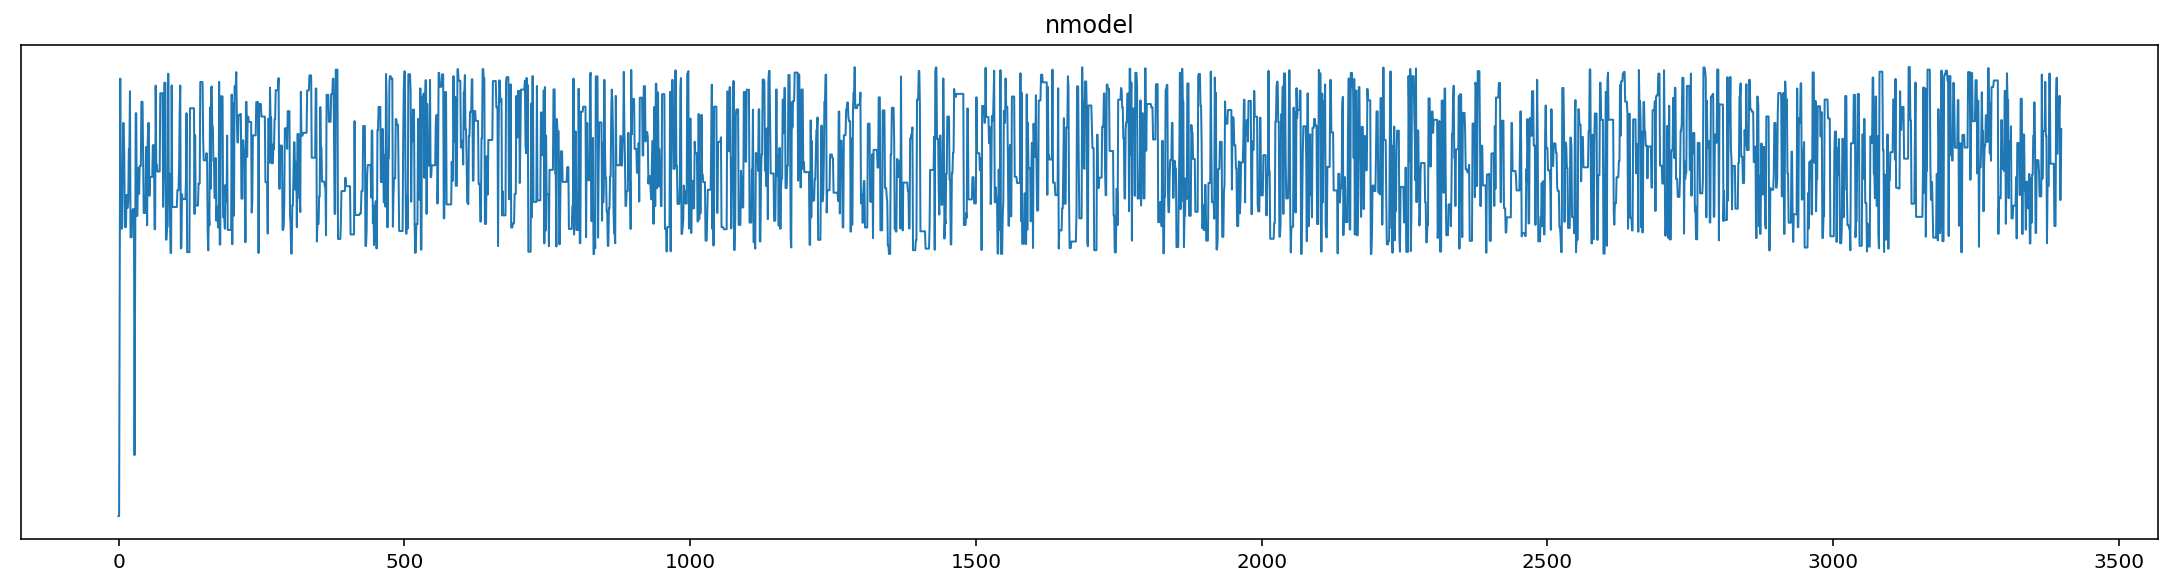

In [449]:
dg.plot_chains(cH,hist=False,pars=['nmodel'],ncols=1,
               title_y=1.05,suptitle='')

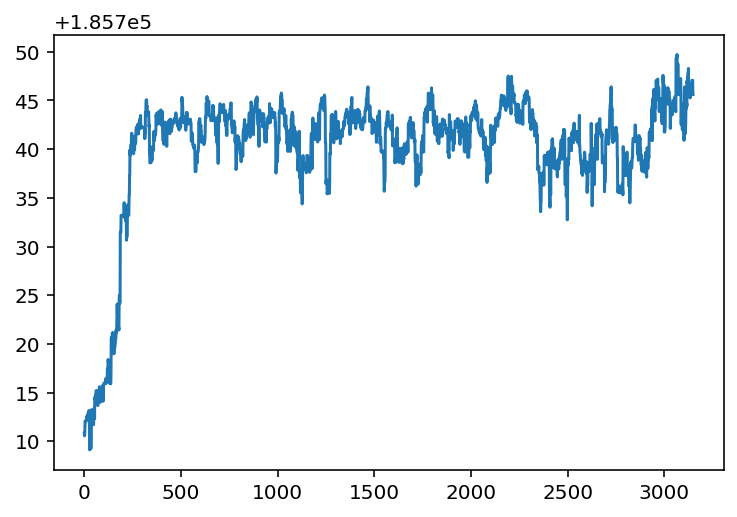

In [450]:
plt.plot(cH.get_param('lnlike',to_burn=False)[250:])
plt.show()

### Single model `core`s
A `core.HyperModelCore` object has a method to return __only__ the samples from a particular model. It is nice to look at how various parameters, say for achromatic RN or `ECORR`, change from model to model.

When a given pulsar analysis gets stuck in one of the `nmodel` parameters

In [390]:
c0=cH.model_core(0)
c1=cH.model_core(1)
c2=cH.model_core(2)
# c3=cH.model_core(3)
# c4=cH.model_core(4)
# c5=cH.model_core(5)

In [361]:
c2.params

['J1600-3053_Rcvr1_2_GASP_efac',
 'J1600-3053_Rcvr1_2_GASP_log10_ecorr',
 'J1600-3053_Rcvr1_2_GASP_log10_equad',
 'J1600-3053_Rcvr1_2_GUPPI_efac',
 'J1600-3053_Rcvr1_2_GUPPI_log10_ecorr',
 'J1600-3053_Rcvr1_2_GUPPI_log10_equad',
 'J1600-3053_Rcvr_800_GASP_efac',
 'J1600-3053_Rcvr_800_GASP_log10_ecorr',
 'J1600-3053_Rcvr_800_GASP_log10_equad',
 'J1600-3053_Rcvr_800_GUPPI_efac',
 'J1600-3053_Rcvr_800_GUPPI_log10_ecorr',
 'J1600-3053_Rcvr_800_GUPPI_log10_equad',
 'J1600-3053_dm_gp_log10_alpha_wgt',
 'J1600-3053_dm_gp_log10_ell',
 'J1600-3053_dm_gp_log10_ell2',
 'J1600-3053_dm_gp_log10_sigma',
 'J1600-3053_red_noise_gamma',
 'J1600-3053_red_noise_log10_A',
 'J1600-3053_scattering_gp_log10_ell',
 'J1600-3053_scattering_gp_log10_sigma',
 'n_earth',
 'lnlike',
 'lnprior',
 'chain_accept',
 'pt_chain_accept']

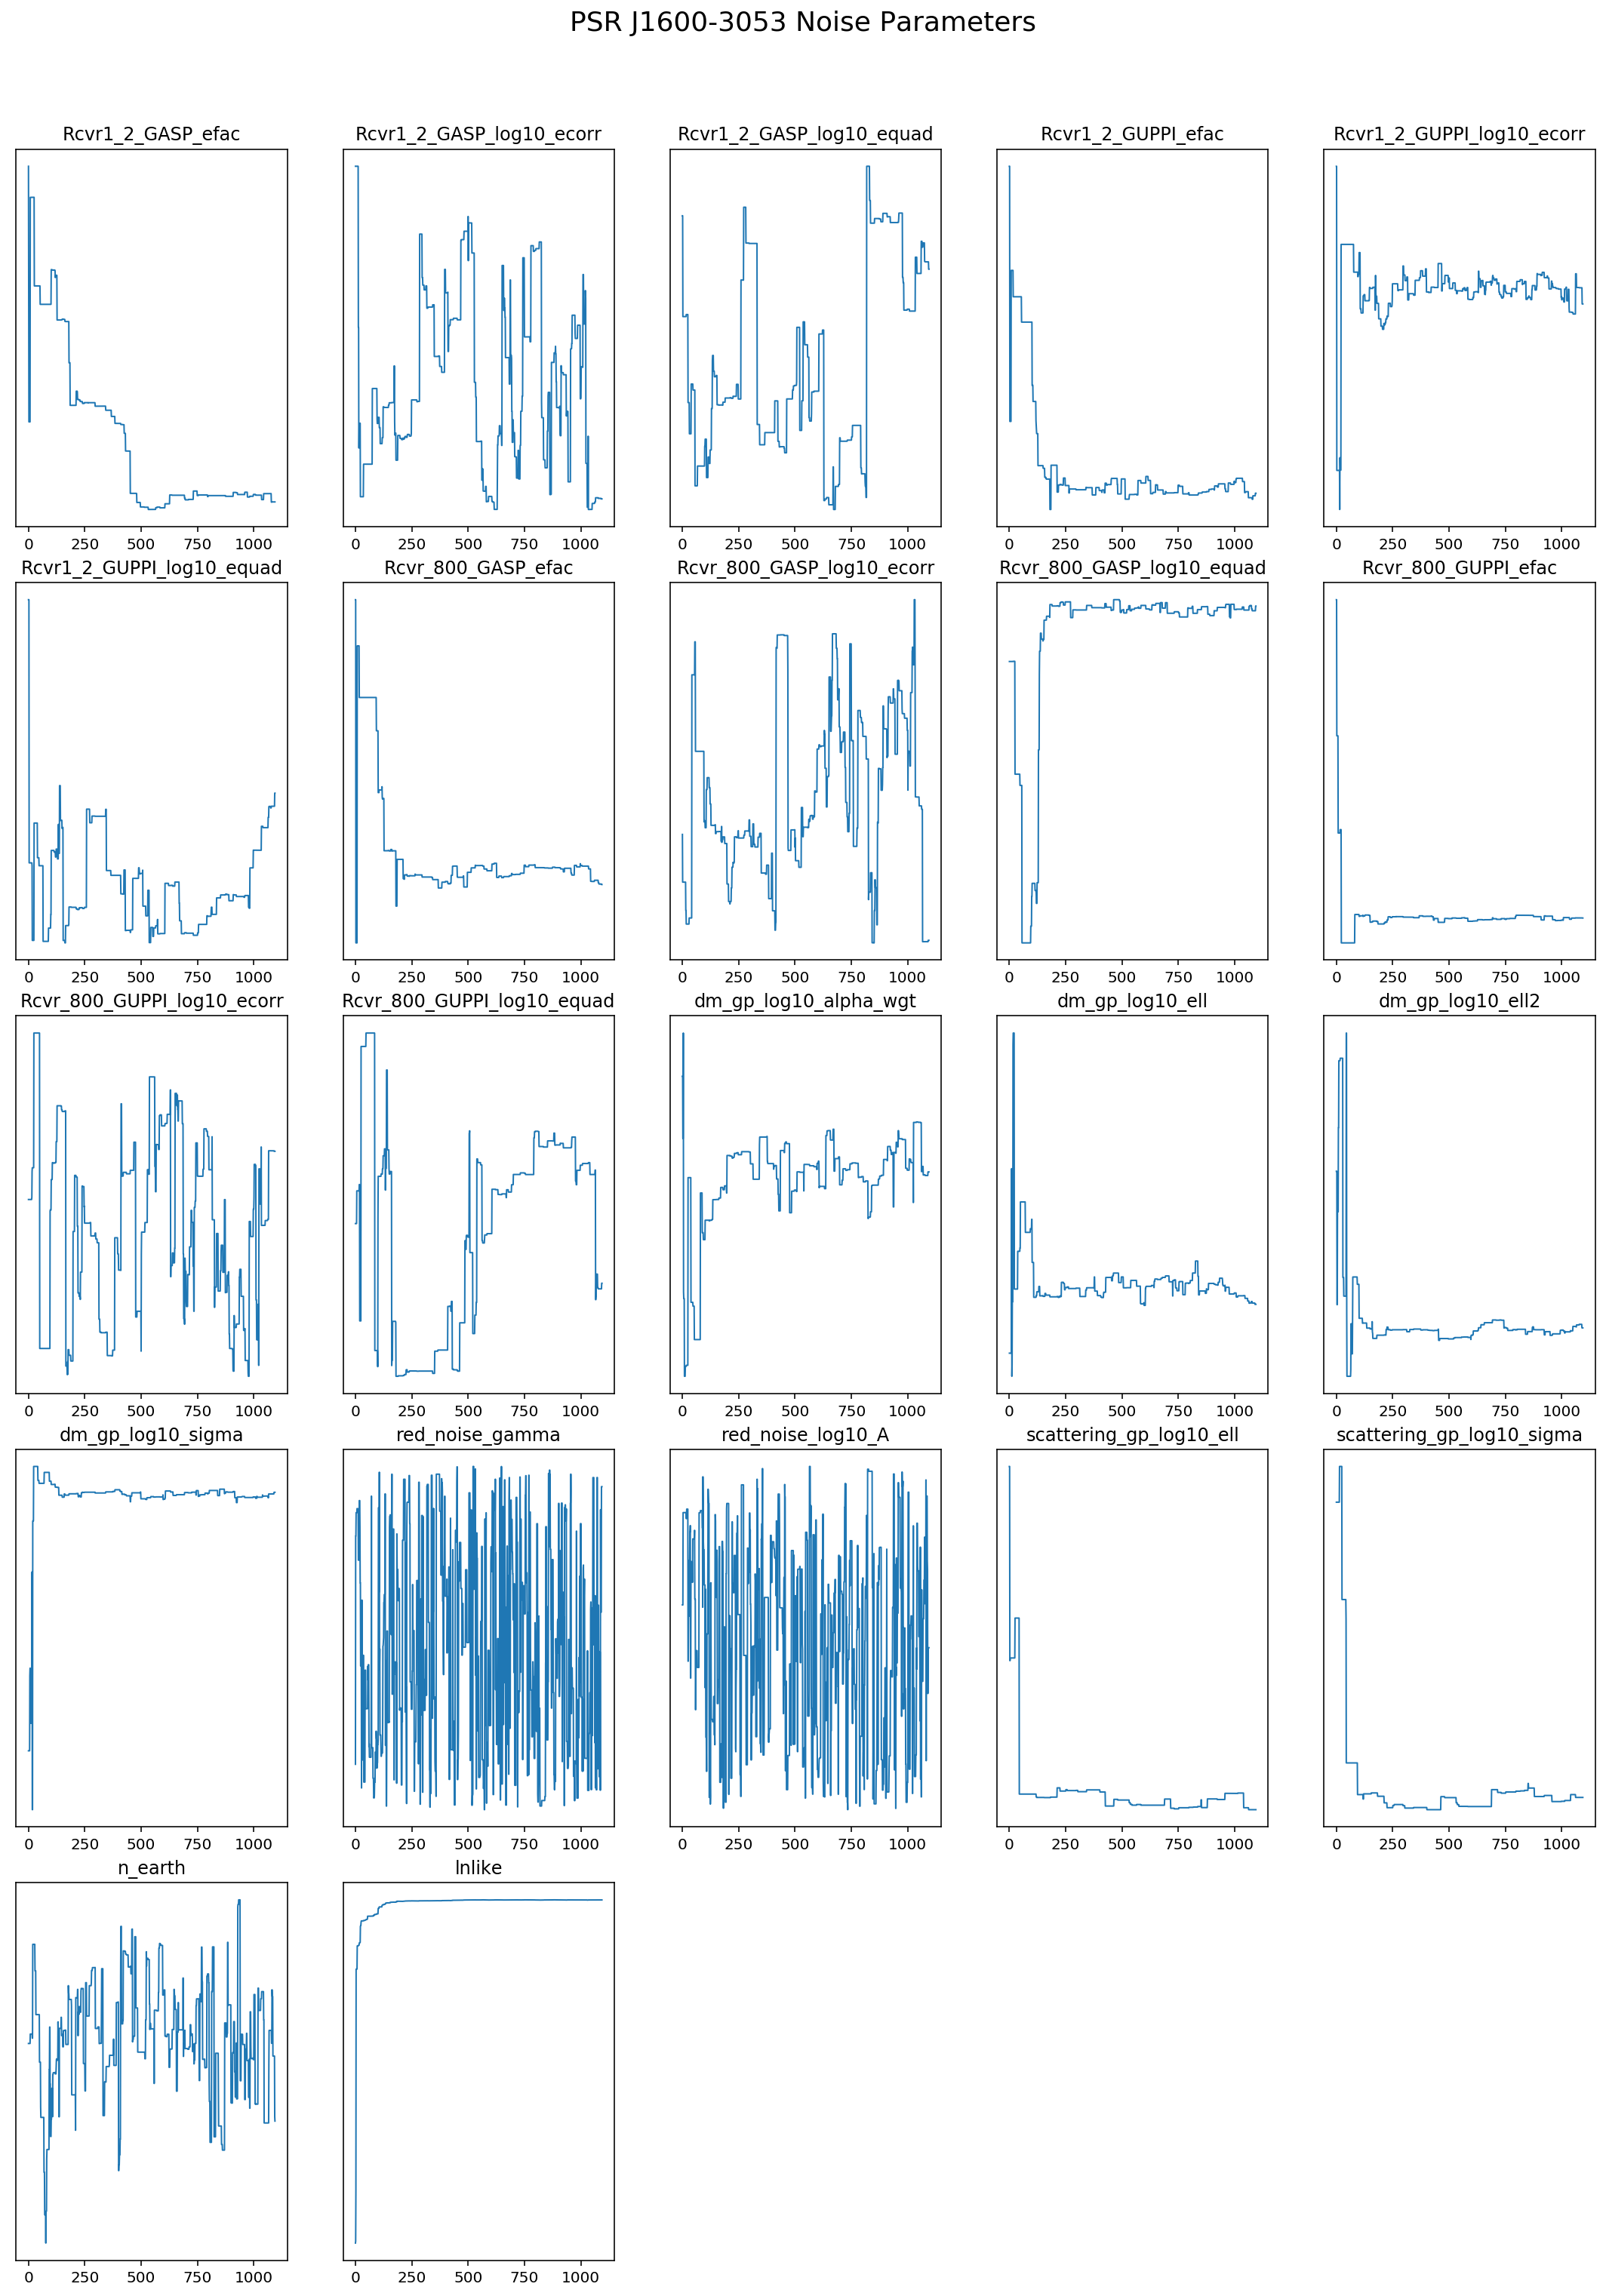

In [362]:
dg.plot_chains(c2, hist=False, ncols=5, title_y=1.05,
               exclude=['lnprior', 'chain_accept', 'pt_chain_accept'])

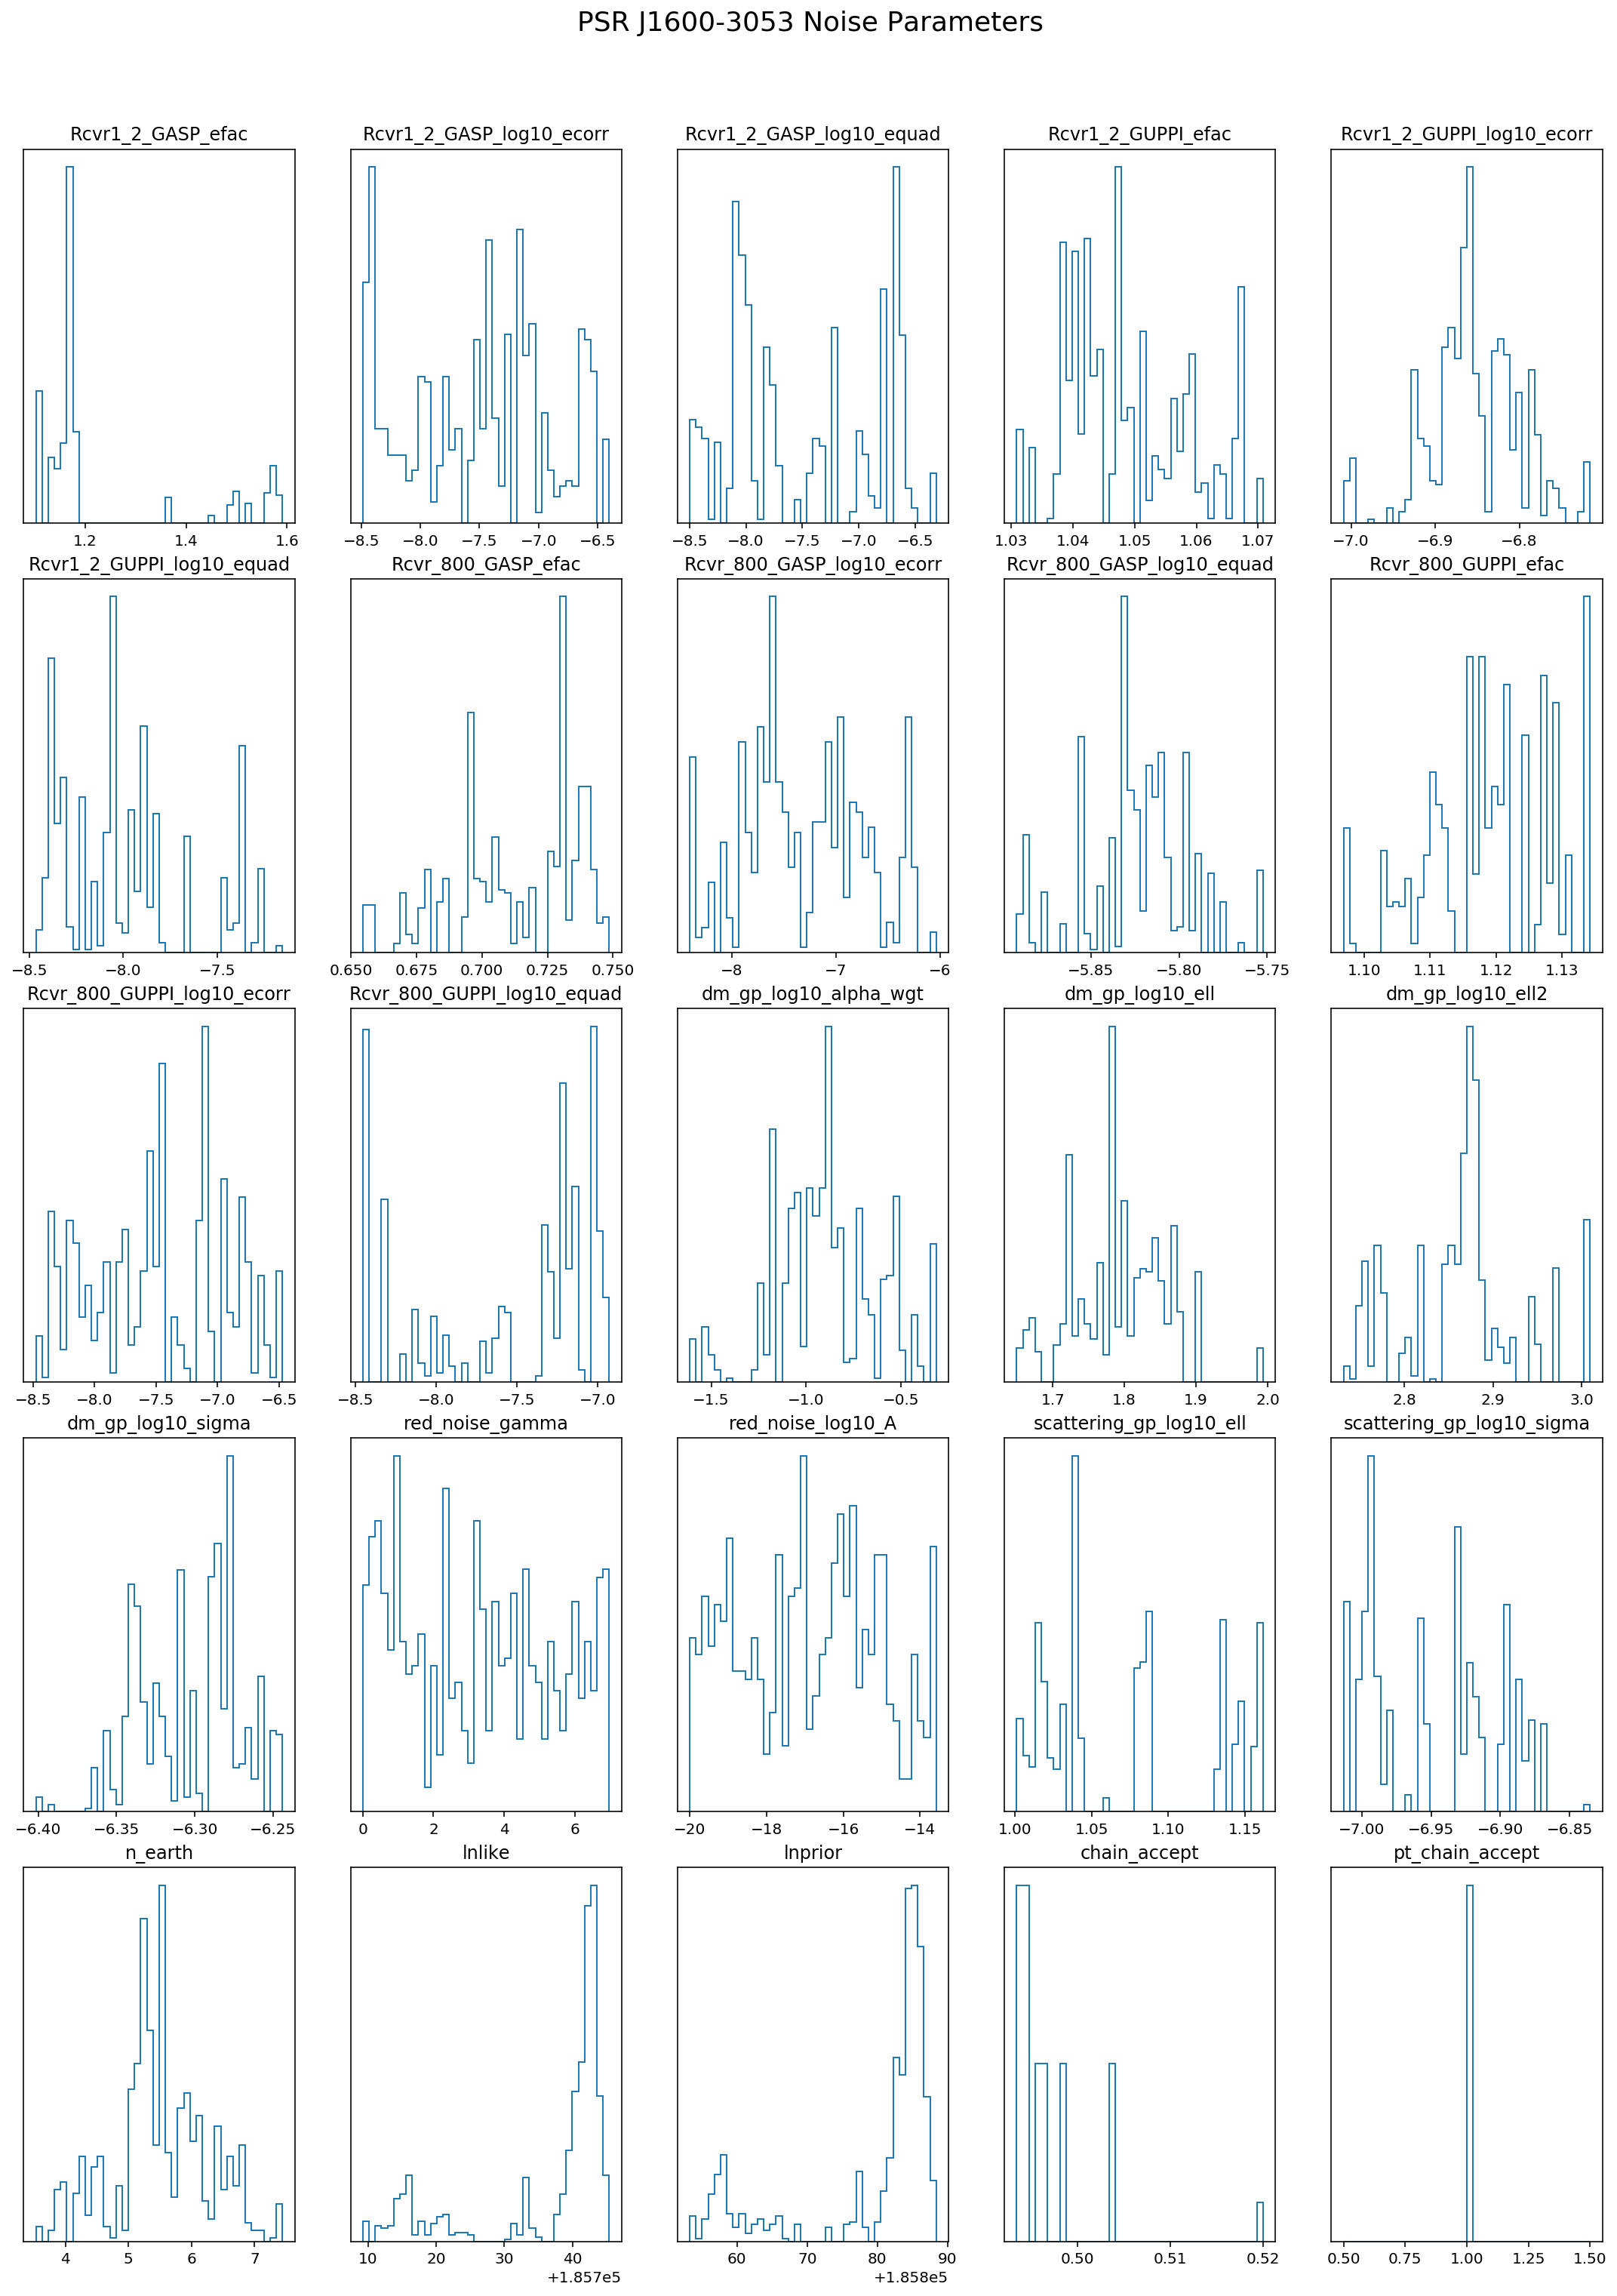

In [363]:
dg.plot_chains(c2, hist=True, ncols=5, title_y=1.05)

In [364]:
with open(chaindir+'/model_labels.json' , 'r') as fin:
    model_labels= json.load(fin)

model_labels

[['A', 'sq_exp_rfband', False, None],
 ['B', 'periodic_rfband', False, None],
 ['C', 'sq_exp_rfband', True, 'sq_exp'],
 ['D', 'sq_exp_rfband', True, 'periodic']]

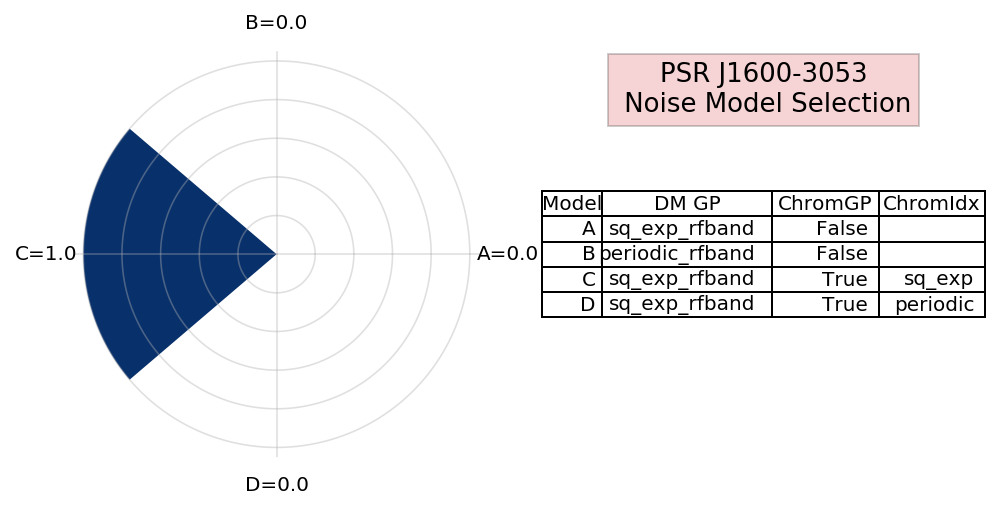

In [365]:
dg.noise_flower(cH, 
                colLabels=['Model','DM GP','ChromGP', 'ChromIdx'],
                #['Model','Achrom', 'DM GP', 'SW GP'],
                cellText=model_labels,
                colWidths=[0.14,0.4,0.25,0.25])

# Gaussian Process Realizations

In [14]:
from enterprise_extensions.models import model_singlepsr_noise

In [15]:
from la_forge.gp import Signal_Reconstruction as gp

In [280]:
# psrname = 'J1911+1347'
filepath = './no_dmx_pickles/'
filepath += '{0}_ng12p5yr_v3_nodmx_ePSR.pkl'.format(psrname)

In [371]:
with open(filepath,'rb') as fin:
    psr=pickle.load(fin)

with open(chaindir+'/model_kwargs.json' , 'r') as fin:
    model_kwargs=json.load(fin)

In [372]:
# ptas = {}
# for ky, kwargs in model_kwargs.items():
#     ptas[int(ky)] = model_singlepsr_noise(psr, **kwargs)

pta= model_singlepsr_noise(psr, **model_kwargs['2'])

The `Signal_Reconstruction` class take an `enterprise.pulsar.Pulsar` object, an `enterprise.signal_base.PTA` object and a `la_forge.core.Core` object as inputs. (One can alternatively use a chain array and burn value for the latter.) 

In [391]:
sr=gp(psr,pta,core=c2)

The `gp_types` atribute will tell you which Gaussian process signals are available in this `PTA`. Additionally there are a number of other options one can use for the `gp_type` flag that goes into a signal reconstruction. These include `['achromatic_rn','DM','FD','all']`. Also any of the timing parameter perturbations can also be called. 

In [392]:
sr.gp_types

['linear_timing_model', 'red_noise', 'dm_gp', 'scattering_gp']

In [393]:
psr.fitpars

['Offset',
 'ELONG',
 'ELAT',
 'F0',
 'F1',
 'DM',
 'DM1',
 'DM2',
 'PMELONG',
 'PMELAT',
 'PX',
 'SINI',
 'PB',
 'T0',
 'A1',
 'OM',
 'ECC',
 'XDOT',
 'M2',
 'FD1',
 'FD2',
 'JUMP1']

In [401]:
# parameter indices to pull from chain. Change `size` flag for more or less.
idxs = np.random.randint(sr.burn, sr.chain.shape[0],size=100)

In [402]:
DM = np.array([sr.reconstruct_signal(gp_type='DM',det_signal=True, idx=idx)[psrname]
               for idx in idxs])

In [403]:
dm_gp = np.array([sr.reconstruct_signal(gp_type='dm_gp', idx=idx)[psrname]
                  for idx in idxs])

In [404]:
# chrom_quad = np.array([sr.reconstruct_signal(gp_type='chromatic_quad', idx=idx)[psrname]
#                     for idx in idxs])

In [405]:
chrom_gp = np.array([sr.reconstruct_signal(gp_type='scattering_gp', idx=idx)[psrname]
                    for idx in idxs])

In [417]:
mlvDM = np.mean(DM,axis=0)
# sr.reconstruct_signal(gp_type='DM',det_signal=True, mlv=True)[psrname]
mlv_dmgp =sr.reconstruct_signal(gp_type='dm_gp', mlv=True)[psrname]
# mlv_cq = sr.reconstruct_signal(gp_type='chromatic_quad', mlv=True)[psrname]
mlv_sgp =sr.reconstruct_signal(gp_type='scattering_gp', mlv=True)[psrname]

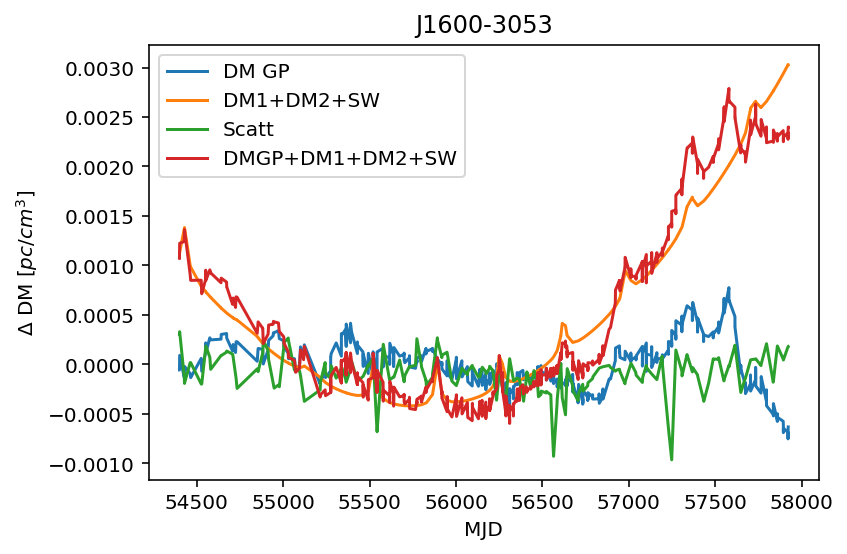

In [418]:
plt.plot(psr.toas/(24*3600),(mlv_dmgp*psr.freqs**2*2.41e-4),label='DM GP')
plt.plot(psr.toas/(24*3600),(mlvDM*psr.freqs**2*2.41e-4),label='DM1+DM2+SW')
plt.plot(psr.toas/(24*3600),(mlv_sgp*psr.freqs**4*2.41e-10),label='Scatt')
plt.plot(psr.toas/(24*3600),((mlv_dmgp+mlvDM)*psr.freqs**2*2.41e-4),label='DMGP+DM1+DM2+SW')
# plt.ylim(-10,10)
plt.legend()#loc='lower left')
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)
plt.show()

## Plot DMX
Use the DMX values from the data release as a comparison of how well the DM GP models are matching the changes in the dispersion measure.

In [476]:
#Load DMX values
dtypes = {'names': ('DMXEP', 'DMX_value', 'DMX_var_err', 
                    'DMXR1', 'DMXR2', 'DMXF1', 
                    'DMXF2', 'DMX_bin'),
          'formats': ('f4','f4','f4','f4','f4','f4','f4','U6')}
dmx = np.loadtxt('./dmx/{0}_NANOGrav_12yv3.dmx'.format(psrname),
                 skiprows=4,
                 dtype=dtypes)

In [407]:
# Convert signals into units of DM [pc/cm^3]
dm_units = (dm_gp + DM)*psr.freqs[np.newaxis,:]**2*2.41e-4 
dm_mlv = (mlvDM + mlv_dmgp)*psr.freqs**2*2.41e-4

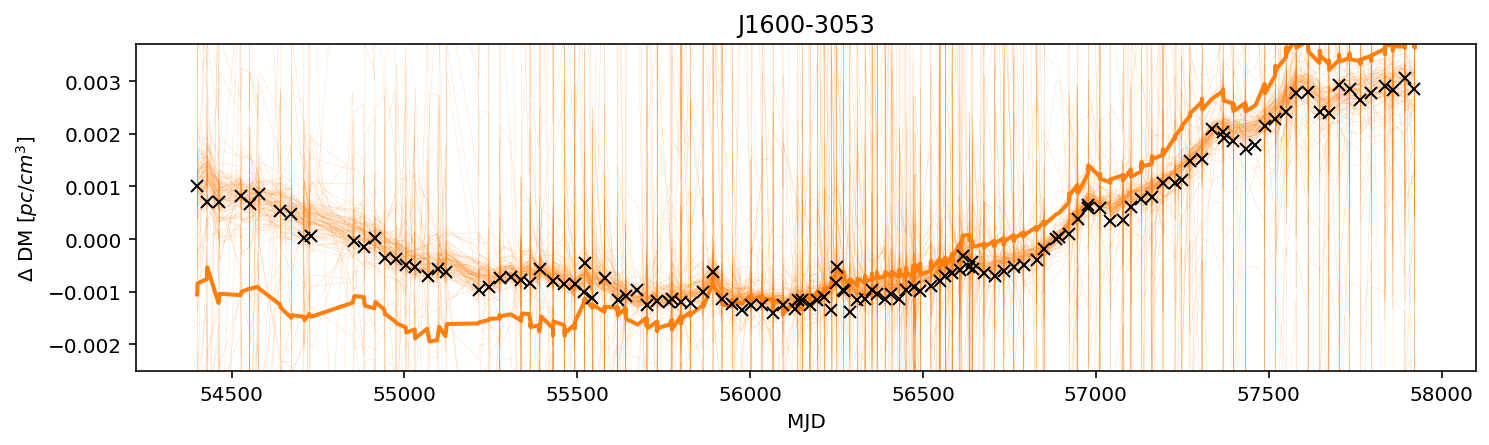

In [419]:
plt.figure(figsize=[12,3])
for dm in dm_units:
    plt.plot(psr.toas/(24*3600),dm-dm.mean(),linewidth=0.2,alpha=0.3,color='C1')

plt.plot(psr.toas/(24*3600),dm_mlv-dm_mlv.mean(),linewidth=2,color='C1')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
#              yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')

plt.ylim(-0.0025,0.0037) # J1600
#plt.ylim(-0.0015,0.0023) # J1911
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)
plt.show()

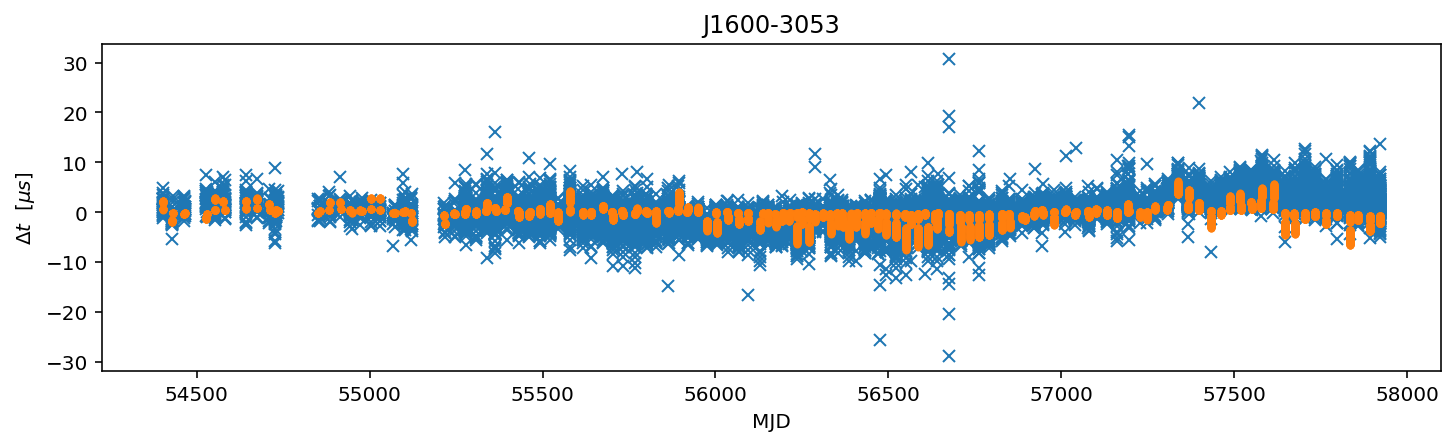

In [420]:
quadDM_resids = psr.residuals-mlvDM-(psr.residuals-mlvDM).mean()

plt.figure(figsize=[12,3])
plt.plot(psr.toas/(24*3600), quadDM_resids*1e6, 'x')
plt.plot(psr.toas/(24*3600), (mlv_dmgp+mlv_sgp)*1e6, '.')
# plt.ylim(-10,10)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta t$  [$\mu s$]')
plt.title(psrname)
plt.show()

In [453]:
mlv_sw =sr.reconstruct_signal(gp_type='DM',det_signal=True, mlv=True)[psrname]

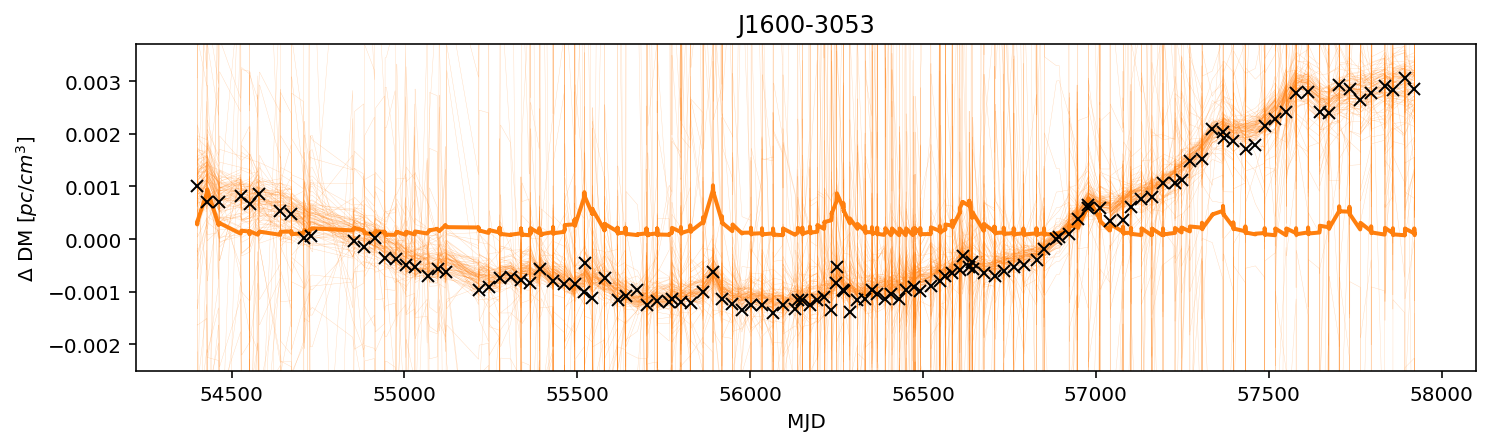

In [441]:
plt.figure(figsize=[12,3])
for dm in dm_units:
    plt.plot(psr.toas/(24*3600),dm-dm.mean(),linewidth=0.2,alpha=0.3,color='C1')

plt.plot(psr.toas/(24*3600),2*mlv_sw*psr.freqs**2*2.41e-4 ,linewidth=2,color='C1')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
#              yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')

plt.ylim(-0.0025,0.0037) # J1600
#plt.ylim(-0.0015,0.0023) # J1911
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)
plt.show()

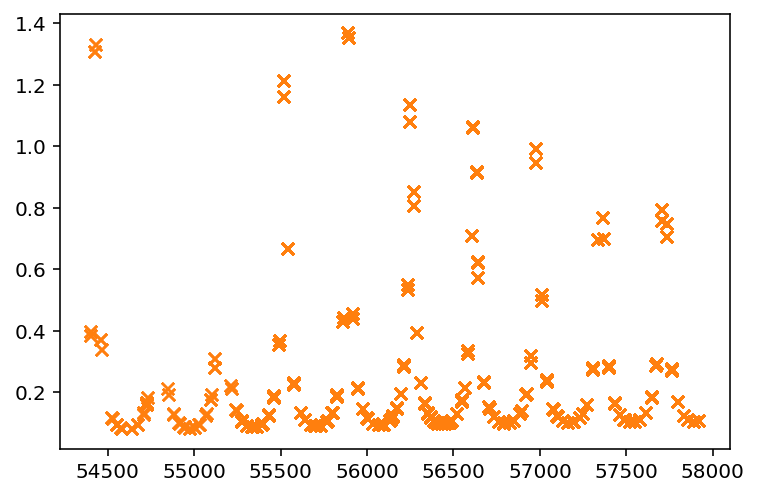

In [454]:
plt.plot(psr.toas/(24*3600),mlv_sw*psr.freqs**2 ,'x',linewidth=2,color='C1')

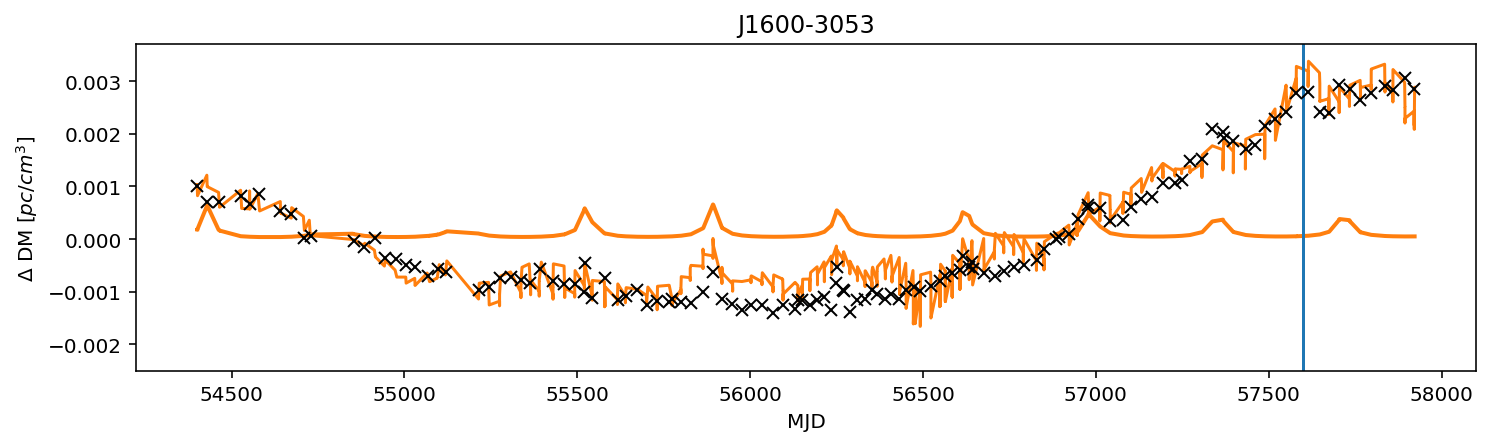

In [472]:
plt.figure(figsize=[12,3])
# for dm in dm_units:
plt.plot(psr.toas/(24*3600),np.mean(dm_units-dm_units.mean(),axis=0),color='C1')

plt.plot(psr.toas/(24*3600),2*mlv_sw*psr.freqs**2*2.41e-4 ,linewidth=2,color='C1')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
#              yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')

plt.ylim(-0.0025,0.0037) # J1600
#plt.ylim(-0.0015,0.0023) # J1911
plt.axvline(57600)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)
plt.show()

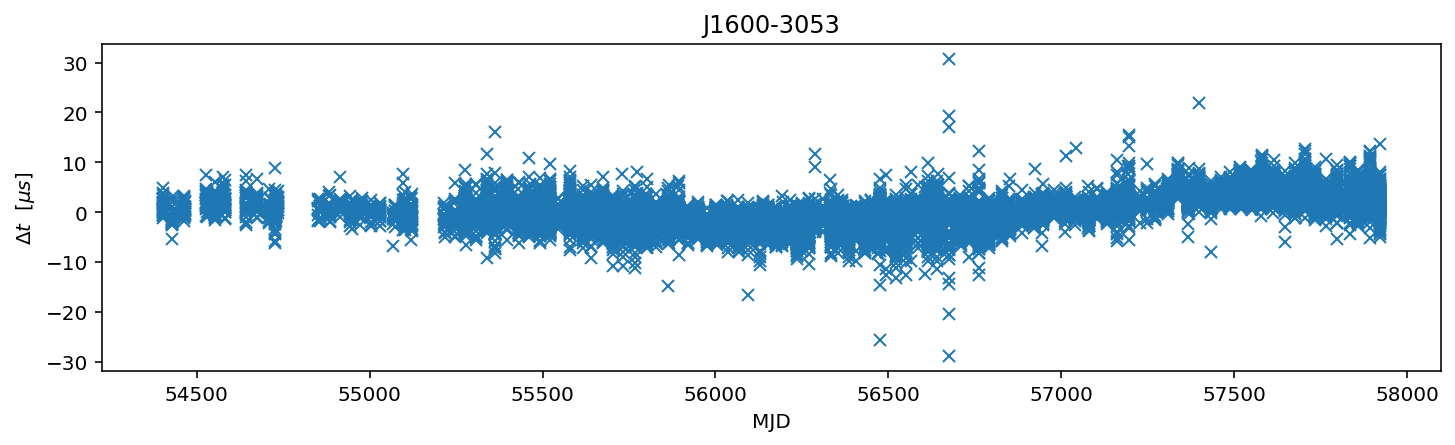

In [456]:
quadDM_resids = psr.residuals-mlvDM-(psr.residuals-mlvDM).mean()

plt.figure(figsize=[12,3])
plt.plot(psr.toas/(24*3600), quadDM_resids*1e6, 'x')
# plt.plot(psr.toas/(24*3600), (mlv_dmgp+mlv_sgp)*1e6, '.')
# plt.ylim(-10,10)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta t$  [$\mu s$]')
plt.title(psrname)
plt.show()

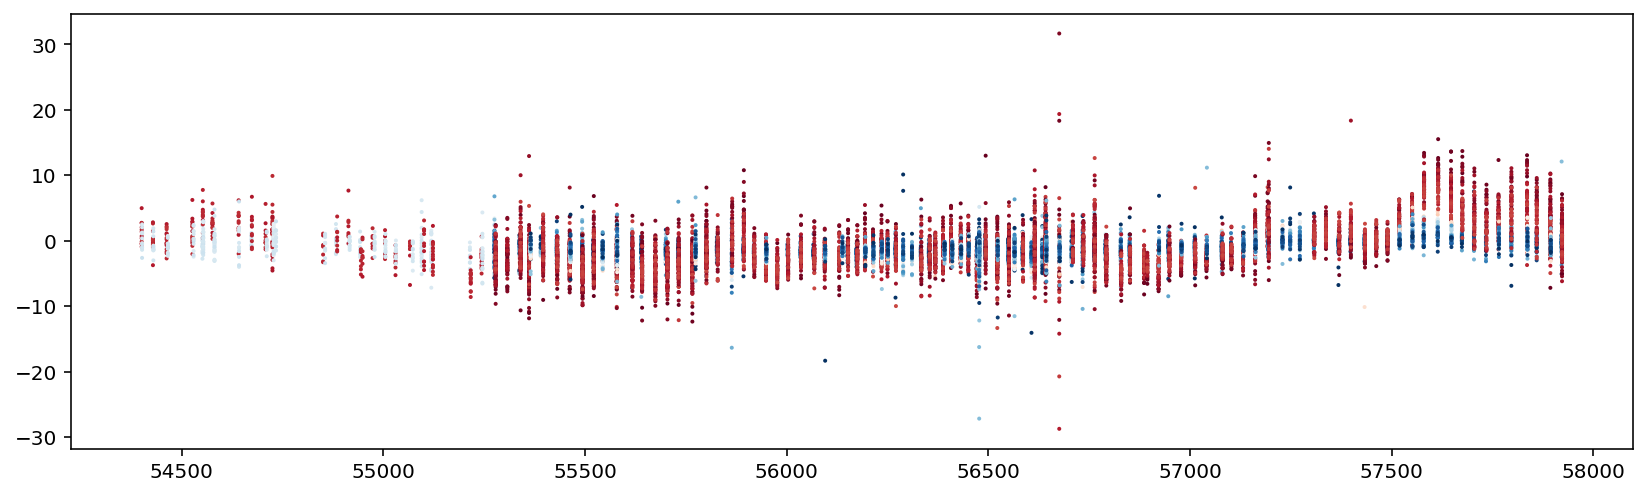

In [463]:
sec_to_day = 24*3600
plt.figure(figsize=[14,4])
plt.scatter(x=psr.toas/sec_to_day,
            y=(psr.residuals-mlvDM)*1e6,
            s=1,
            c=psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
plt.show()

In [508]:
chrom_gp_mean = np.mean(chrom_gp,axis=0)

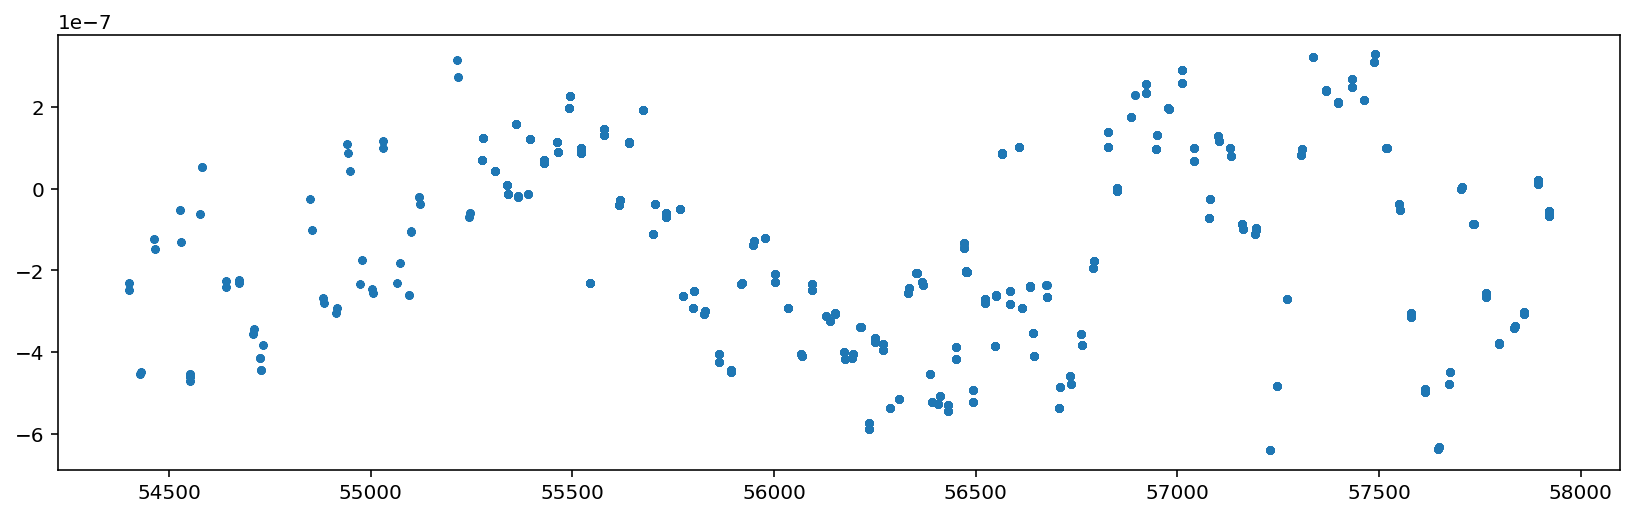

In [470]:
plt.figure(figsize=[14,4])
plt.plot(psr.toas/sec_to_day,np.mean(chrom_gp,axis=0)*(psr.freqs/1400)**4,'.')

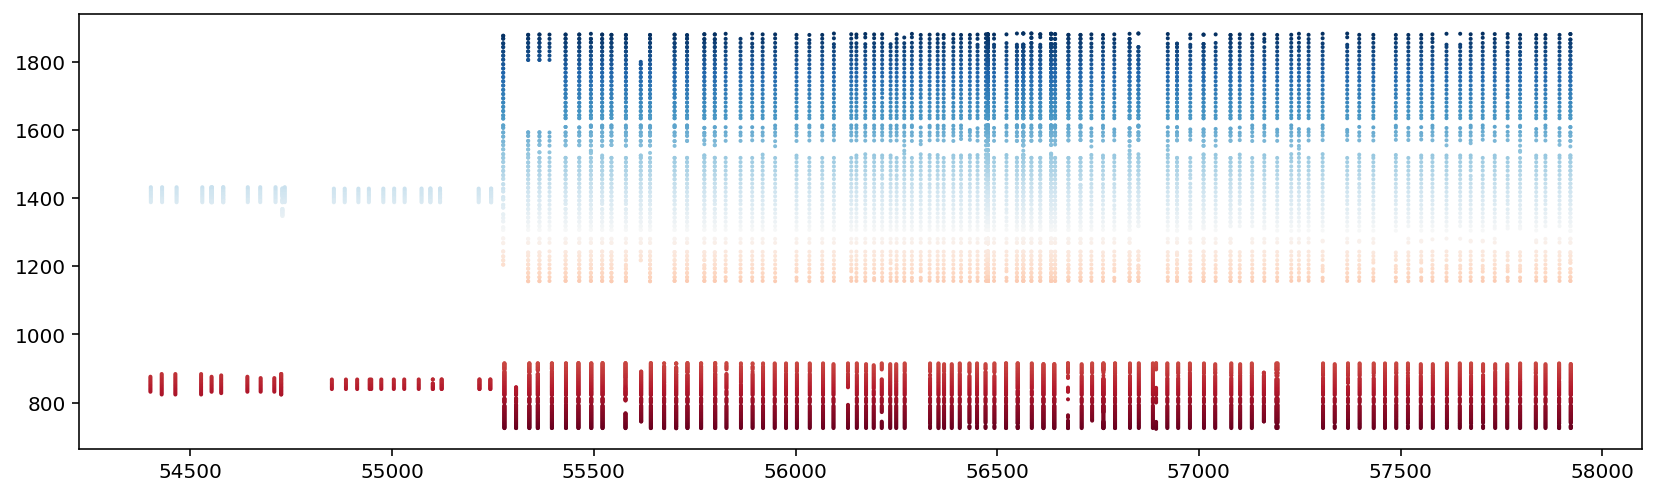

In [473]:
sec_to_day = 24*3600
plt.figure(figsize=[14,4])
plt.scatter(x=psr.toas/sec_to_day,
            y=psr.freqs,
            s=1,
            c=psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
plt.show()

In [474]:
from scipy.stats import binned_statistic

In [572]:
def weight_ave(r_sigma):
    half = r_sigma.size//2
    r = r_sigma[0::2]
    sigma = r_sigma[1::2]
    return np.mean(sigma)**2*np.mean(r/sigma**2)

In [573]:
high_res = (psr.residuals-mlvDM-chrom_gp_mean)[psr.freqs>1000]
high_res_sigma = np.empty((2*high_res.size), dtype=high_res.dtype)
high_res_sigma[0::2] = high_res
high_res_sigma[1::2] = psr.toaerrs[psr.freqs>1000]
low_res = (psr.residuals-mlvDM-chrom_gp_mean)[psr.freqs<=1000]
low_res_sigma = np.empty((2*low_res.size), dtype=low_res.dtype)
low_res_sigma[0::2] = low_res
low_res_sigma[1::2] = psr.toaerrs[psr.freqs<=1000]

In [586]:
mean_resid_high = binned_statistic(psr.toas[psr.freqs>1000]/sec_to_day,
                                   values=high_res,
                                   bins=dmx['DMXR1'],
                                   statistic='mean')
mean_resid_low = binned_statistic(psr.toas[psr.freqs<=1000]/sec_to_day,
                                   values=low_res,
                                   bins=dmx['DMXR1'],
                                   statistic='mean')

In [581]:

# mean_resid_high = binned_statistic(np.repeat(psr.toas,2)[np.repeat(psr.freqs,2)>1000]/sec_to_day,
#                                    values=high_res_sigma,
#                                    bins=dmx['DMXR1'],
#                                    statistic=weight_ave)
# mean_resid_low = binned_statistic(np.repeat(psr.toas,2)[np.repeat(psr.freqs,2)<=1000]/sec_to_day,
#                                    values=low_res_sigma,
#                                    bins=dmx['DMXR1'],
#                                    statistic=weight_ave)

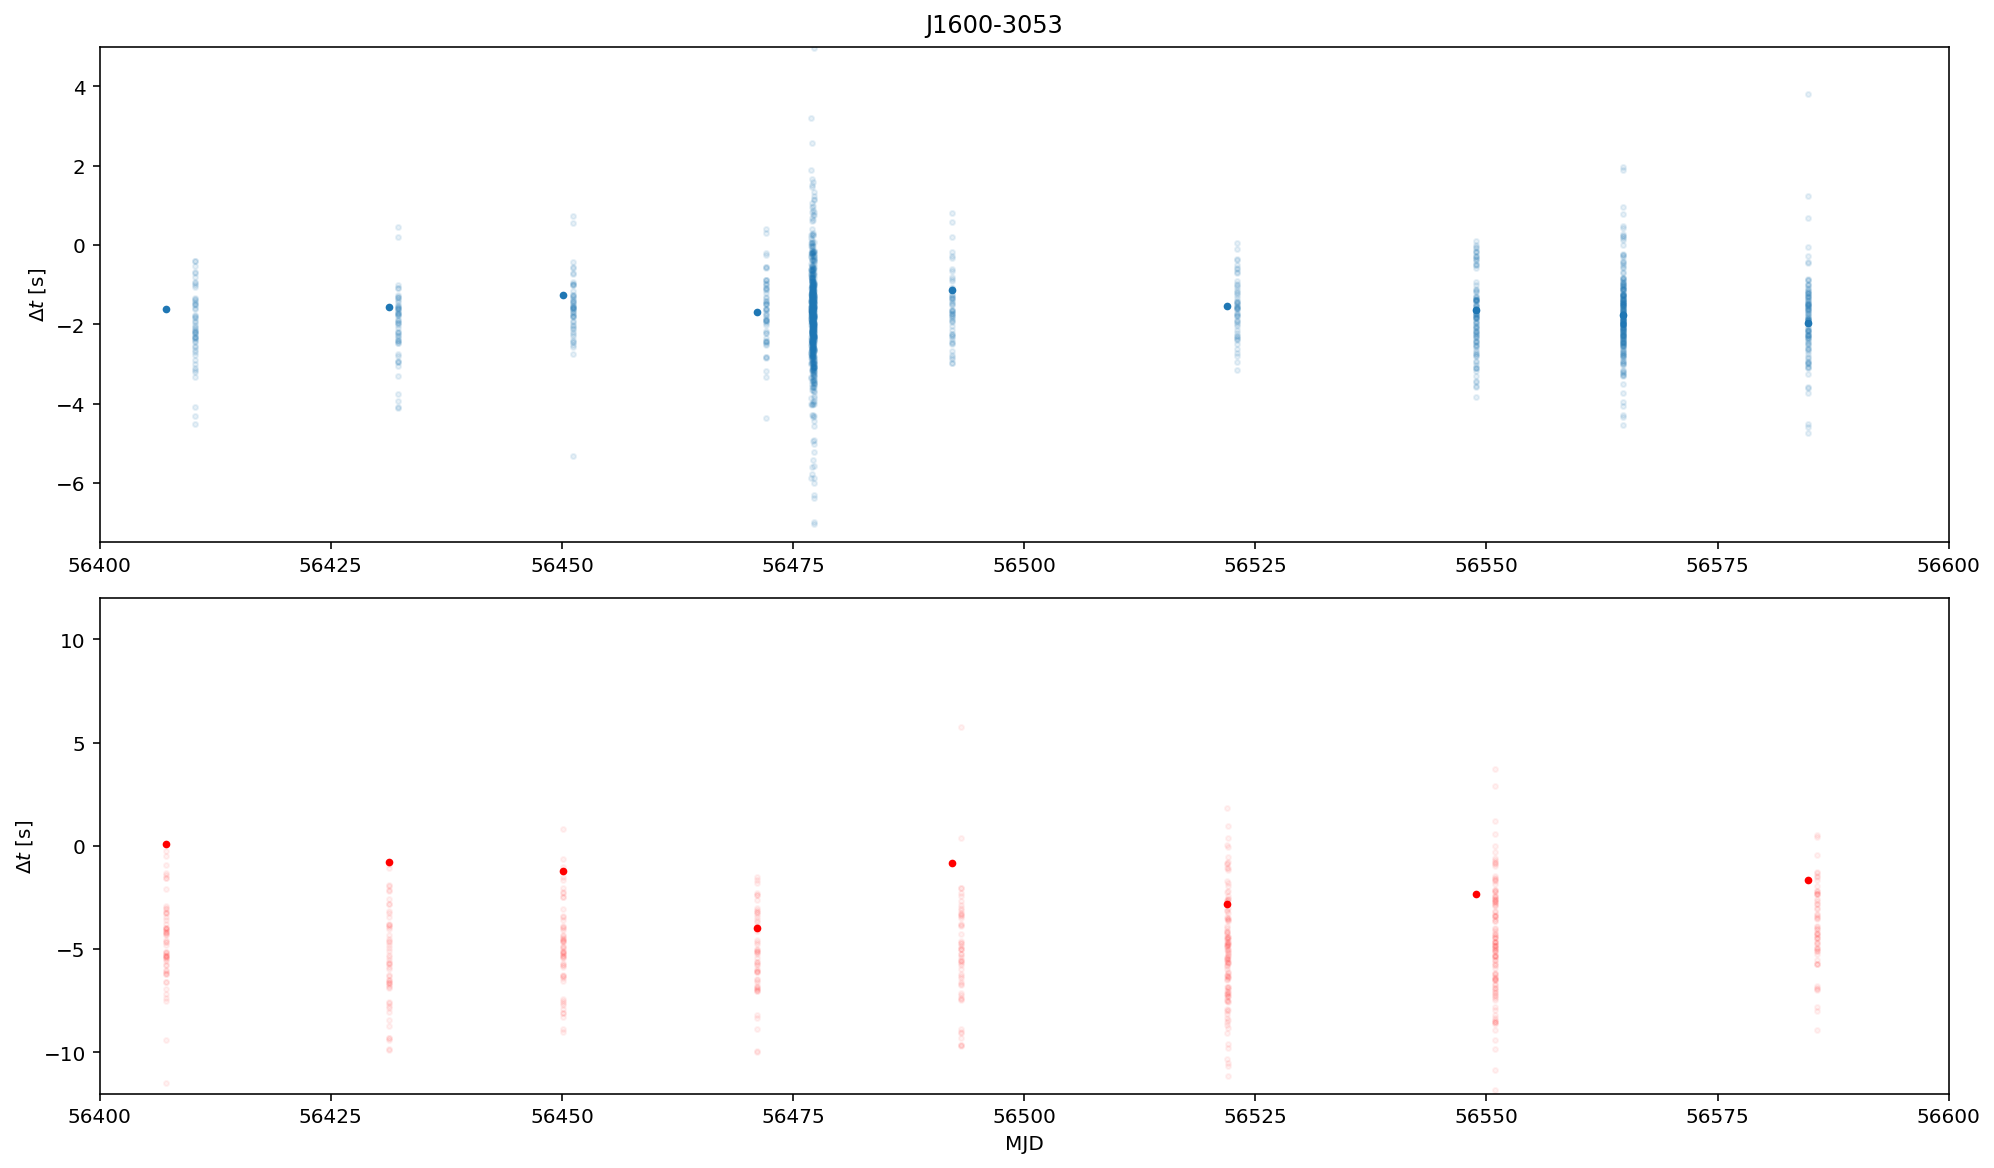

In [588]:
sec_to_day = 24*3600
fig=plt.figure(figsize=[14,8])
fig.add_subplot(211)
plt.scatter(x=dmx['DMXR1'][:-1],
            y=mean_resid_high[0]*1e6,
            s=8,c='C0')
plt.scatter(x=psr.toas[psr.freqs>1000]/sec_to_day,
            y=(psr.residuals-mlvDM)[psr.freqs>1000]*1e6,
            s=6,
            c='C0',alpha=0.1)
plt.ylim(-7.5,5)
plt.xlim(56400,56600)
plt.ylabel(r'$\Delta t$ [s]')
plt.axvline(57600,linestyle='--',color='k')

fig.add_subplot(212)
plt.scatter(x=dmx['DMXR1'][:-1],
            y=mean_resid_low[0]*1e6,
            s=8,c='red')
plt.scatter(x=psr.toas[psr.freqs<=1000]/sec_to_day,
            y=(psr.residuals-mlvDM)[psr.freqs<=1000]*1e6,
            s=6,
            c='red',alpha=0.05)#psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
plt.xlim(56400,56600)
plt.axvline(57600,linestyle='--',color='k')
plt.ylim(-12,12)

plt.ylabel(r'$\Delta t$ [s]')
plt.xlabel('MJD')
fig.suptitle(psrname,y=1.01)
fig.tight_layout()
plt.show()

In [487]:
dmx['DMXR1'].shape

(128,)

In [489]:
mean_residuals[0].shape

(127,)

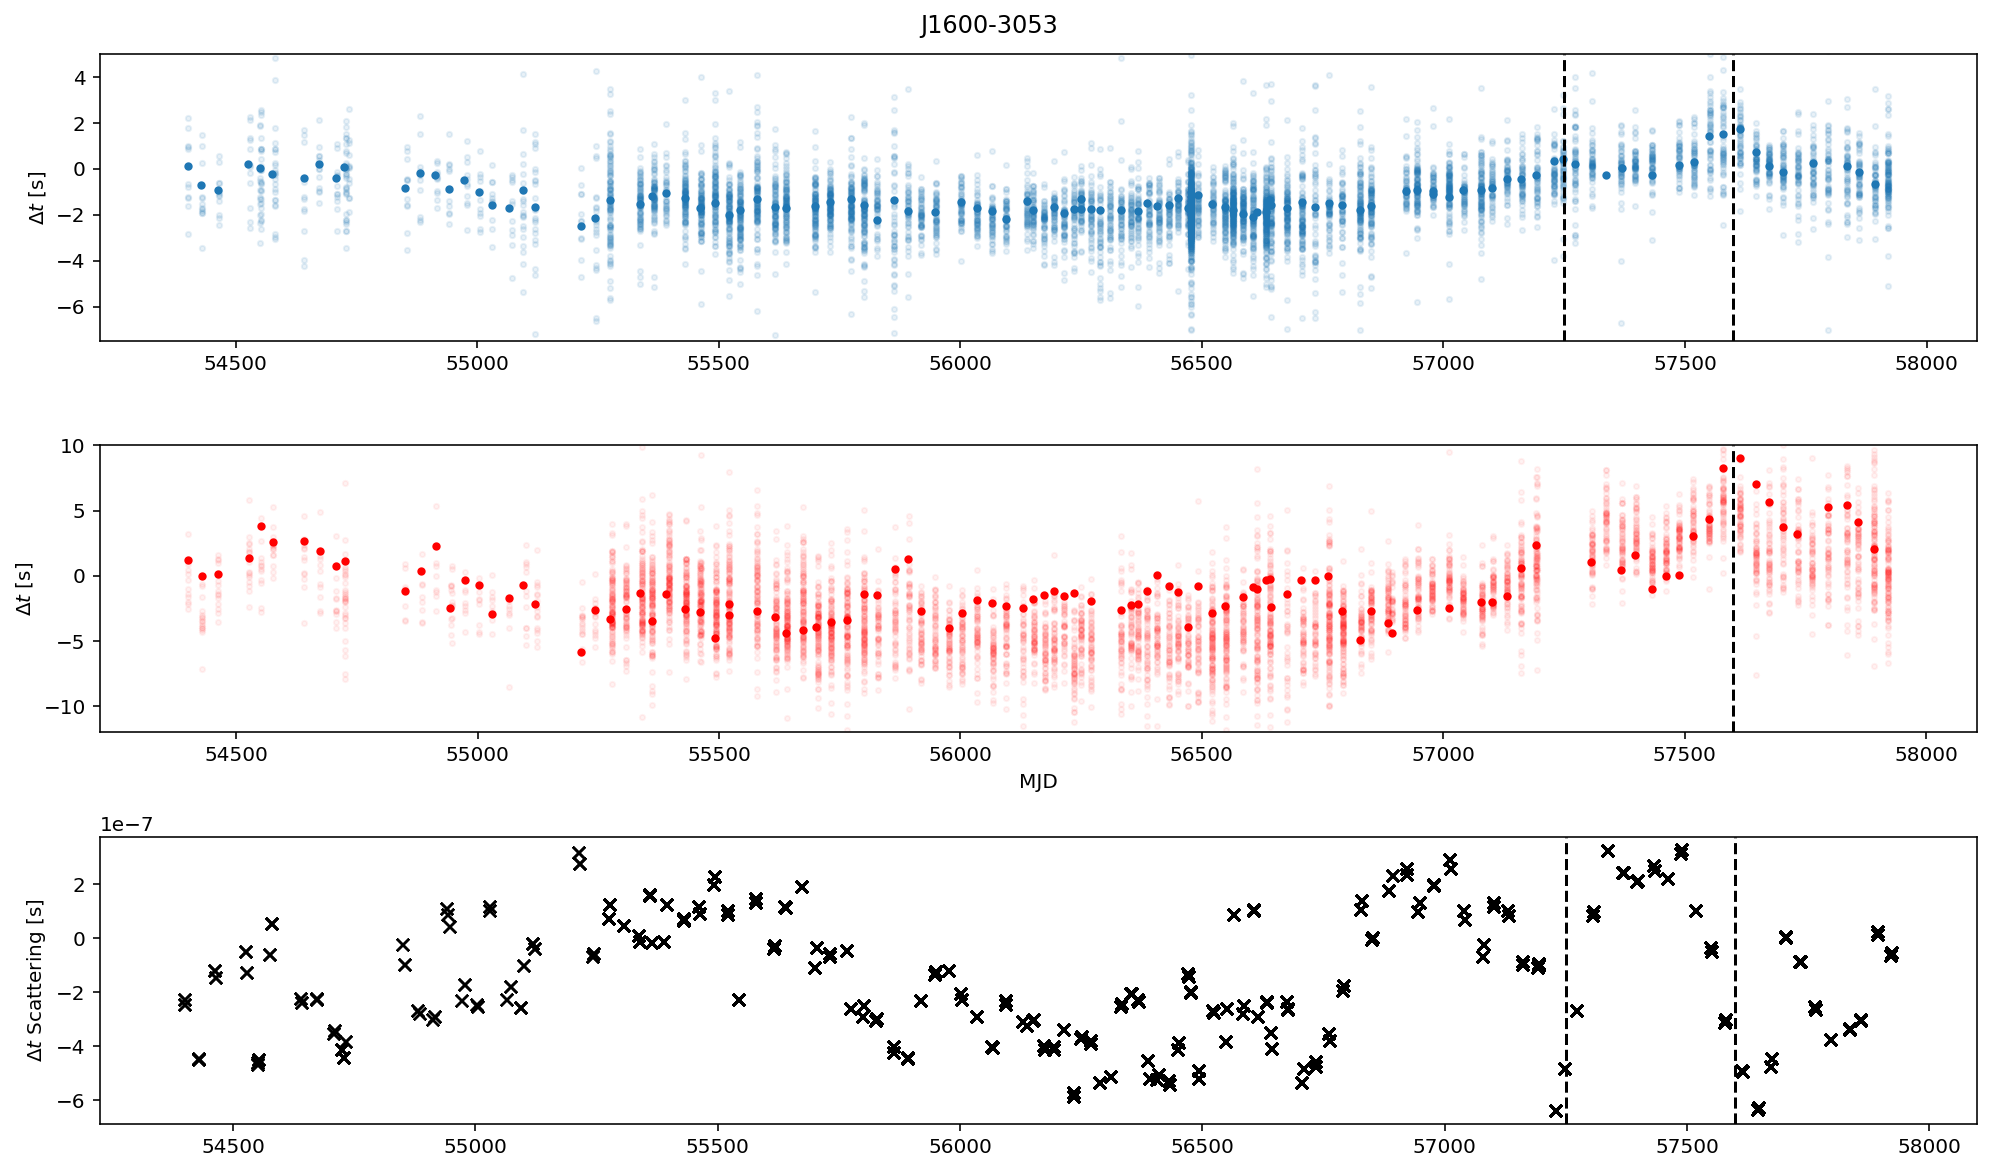

In [537]:
sec_to_day = 24*3600
fig=plt.figure(figsize=[14,8])
fig.add_subplot(311)
plt.scatter(x=dmx['DMXR1'][:-1],
            y=mean_resid_high[0]*1e6,
            s=10,c='C0')
plt.scatter(x=psr.toas[psr.freqs>1000]/sec_to_day,
            y=(psr.residuals-mlvDM)[psr.freqs>1000]*1e6,
            s=7,
            c='C0',alpha=0.1)
plt.ylim(-7.5,5)
plt.ylabel(r'$\Delta t$ [s]')
plt.axvline(57600,linestyle='--',color='k')
plt.axvline(57250,linestyle='--',color='k')

fig.add_subplot(312)
plt.scatter(x=dmx['DMXR1'][:-1],
            y=mean_resid_low[0]*1e6,
            s=10,c='red')
plt.scatter(x=psr.toas[psr.freqs<=1000]/sec_to_day,
            y=(psr.residuals-mlvDM)[psr.freqs<=1000]*1e6,
            s=7,
            c='red',alpha=0.05)#psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
plt.axvline(57600,linestyle='--',color='k')
plt.ylim(-12,10)

plt.ylabel(r'$\Delta t$ [s]')
plt.xlabel('MJD')

fig.add_subplot(313)
plt.plot(psr.toas/sec_to_day,np.mean(chrom_gp,axis=0)*(psr.freqs/1400)**4,'x',color='k')
plt.axvline(57600,linestyle='--',color='k')
plt.axvline(57250,linestyle='--',color='k')
plt.ylabel(r'$\Delta t$ Scattering [s]')
fig.suptitle(psrname,y=1.01)
fig.tight_layout(pad=1.01)
plt.show()



